In [1]:
import anndata as ad
import numpy as np
import pandas as pd

In [2]:
import scanpy as sc

In [3]:
from scanpro import scanpro, anova, t_test
from scanpro.linear_model import create_design
from scanpro.get_transformed_props import get_transformed_props

In [4]:
import matplotlib.pyplot as plt

In [ ]:
# Load the subset file
adata = ad.read_h5ad("/rds/general/user/tf424/home/pmc_20_participants_v2.h5ad")

In [ ]:
# Check the column names
print(adata.obs.columns)

Index(['sample_id', 'participant_id', 'cell_type', 'brain_region', 'sex',
       'diagnosis_at_baseline', 'diagnosis_latest',
       'case_control_other_at_baseline', 'case_control_other_latest', 'guid',
       'study', 'study_participant_id'],
      dtype='object')


In [ ]:
# Count cells by diagnosis group
adata.obs['diagnosis'].value_counts()

In [8]:
print("Unique values:", adata.obs['diagnosis_latest'].unique())

Unique values: ['No PD Nor Other Neurological Disorder', 'Parkinson's Disease']
Categories (2, object): ['No PD Nor Other Neurological Disorder', 'Parkinson's Disease']


In [9]:
# Rename diagnosis labels
adata.obs['diagnosis_latest'] = adata.obs['diagnosis_latest'].replace({
    "No PD Nor Other Neurological Disorder": "HC",
    "Parkinson's Disease": "PD"
})

In [10]:
# Check the updated values
print(adata.obs['diagnosis_latest'].unique())
print(adata.obs['diagnosis_latest'].value_counts())

['HC', 'PD']
Categories (2, object): ['HC', 'PD']
PD    62477
HC    56200
Name: diagnosis_latest, dtype: int64


In [21]:
out = scanpro.scanpro(
    adata,
    clusters_col="cell_type",
    samples_col="participant_id",
    conds_col="diagnosis_latest",
    transform="logit"
)
out.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_HC,mean_props_PD,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
DMNX_Neu,0.000413,0.000546,0.000452,1.208321,-0.338142,0.738680,0.73868
GPI_Neu,0.000042,0.000042,0.000039,1.068022,0.421908,0.677465,0.73868
EN,0.164632,0.171653,0.181002,0.948346,0.343472,0.734727,0.73868
IN,0.118405,0.109554,0.143749,0.762119,-1.202734,0.242730,0.73868
Astro,0.118060,0.129594,0.108292,1.196709,0.645504,0.525730,0.73868
OPC,0.049142,0.057348,0.048366,1.185722,0.590349,0.561382,0.73868
Oligo,0.485090,0.473238,0.456881,1.035801,0.477313,0.638167,0.73868
Micro_PVM,0.050675,0.044499,0.047920,0.928615,0.391426,0.699505,0.73868
Adaptive,0.000430,0.000608,0.000248,2.457466,1.003748,0.327153,0.73868


In [22]:
from statsmodels.stats.multitest import multipletests

raw_p = out.results["p_values"].values
adjusted = multipletests(raw_p, method="fdr_bh")[1]
adjusted


array([0.73868035, 0.73868035, 0.73868035, 0.73868035, 0.73868035,
       0.73868035, 0.73868035, 0.73868035, 0.73868035, 0.73868035,
       0.73868035, 0.73868035])

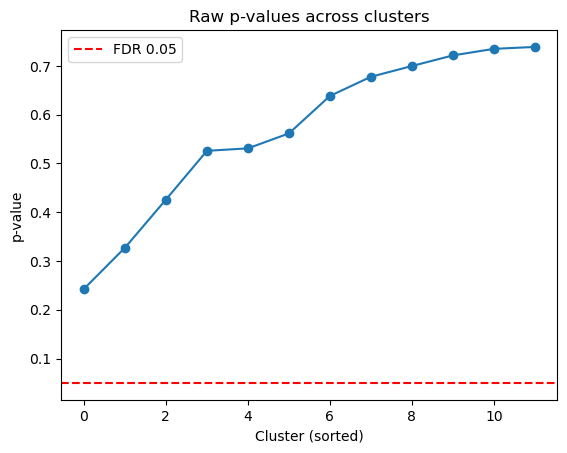

In [23]:
raw_p = out.results["p_values"]
plt.plot(sorted(raw_p), marker="o")
plt.axhline(0.05, color="red", linestyle="--", label="FDR 0.05")
plt.title("Raw p-values across clusters")
plt.ylabel("p-value")
plt.xlabel("Cluster (sorted)")
plt.legend()
plt.show()

In [19]:
out.props

cell_type,DMNX_Neu,GPI_Neu,EN,IN,Astro,OPC,Oligo,Micro_PVM,Adaptive,Mural,Endo,Ependymal
participant_id,,,,,,,,,,,,
PM-HA_S01646,0.000470,0.000000,0.058741,0.154370,0.208412,0.043468,0.467105,0.055921,0.000117,0.008224,0.003172,0.000000
PM-HA_S05527,0.001475,0.000000,0.523599,0.383481,0.001475,0.061947,0.023599,0.001475,0.000000,0.001475,0.001475,0.000000
PM-HA_S11972,0.000000,0.000000,0.189419,0.093477,0.135396,0.042591,0.495180,0.035418,0.000000,0.005380,0.003138,0.000000
PM-HA_S16580,0.000310,0.000000,0.180869,0.164736,0.167218,0.052120,0.347053,0.063082,0.000310,0.019338,0.004447,0.000517
PM-MS_202387,0.000411,0.000000,0.254660,0.172834,0.016721,0.056880,0.429962,0.050987,0.000411,0.009731,0.007401,0.000000
PM-MS_272264,0.001717,0.000000,0.277539,0.217167,0.120458,0.076395,0.236052,0.056366,0.000858,0.007725,0.005722,0.000000
PM-MS_56356,0.000000,0.000000,0.065955,0.015631,0.272207,0.073961,0.492947,0.043080,0.001144,0.009150,0.025925,0.000000
PM-MS_644748,0.000155,0.000000,0.201514,0.098748,0.052542,0.031834,0.565600,0.032143,0.001082,0.005254,0.010972,0.000155
PM-MS_69190,0.000710,0.000000,0.053926,0.086093,0.071665,0.035951,0.714286,0.030984,0.000237,0.004021,0.002129,0.000000


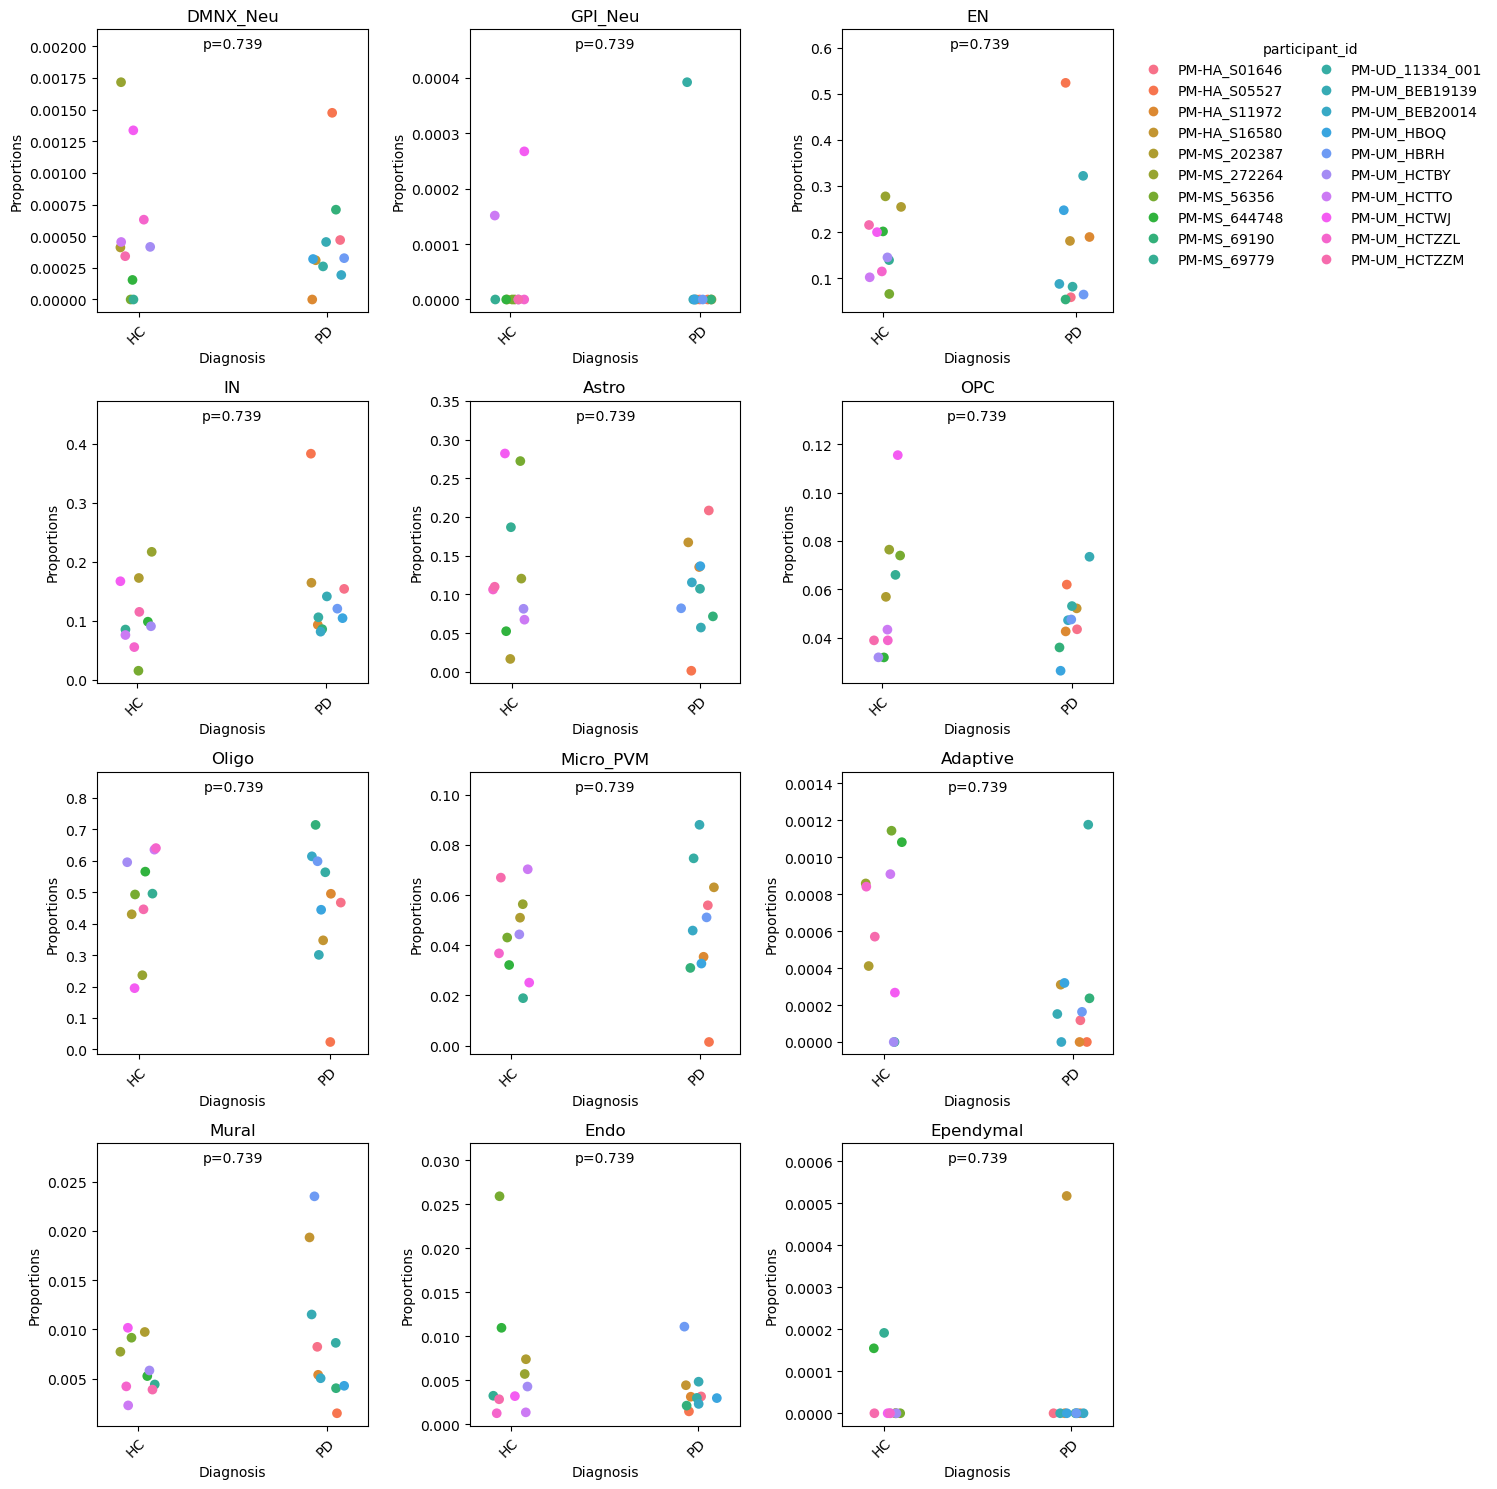

In [29]:
fig = out.plot() 

fig = plt.gcf() 

fig.set_size_inches(15, 15) 

for ax in fig.axes:
    ax.set_xlabel("Diagnosis") 


plt.tight_layout()

plt.savefig("main_clusters.pdf", bbox_inches="tight")

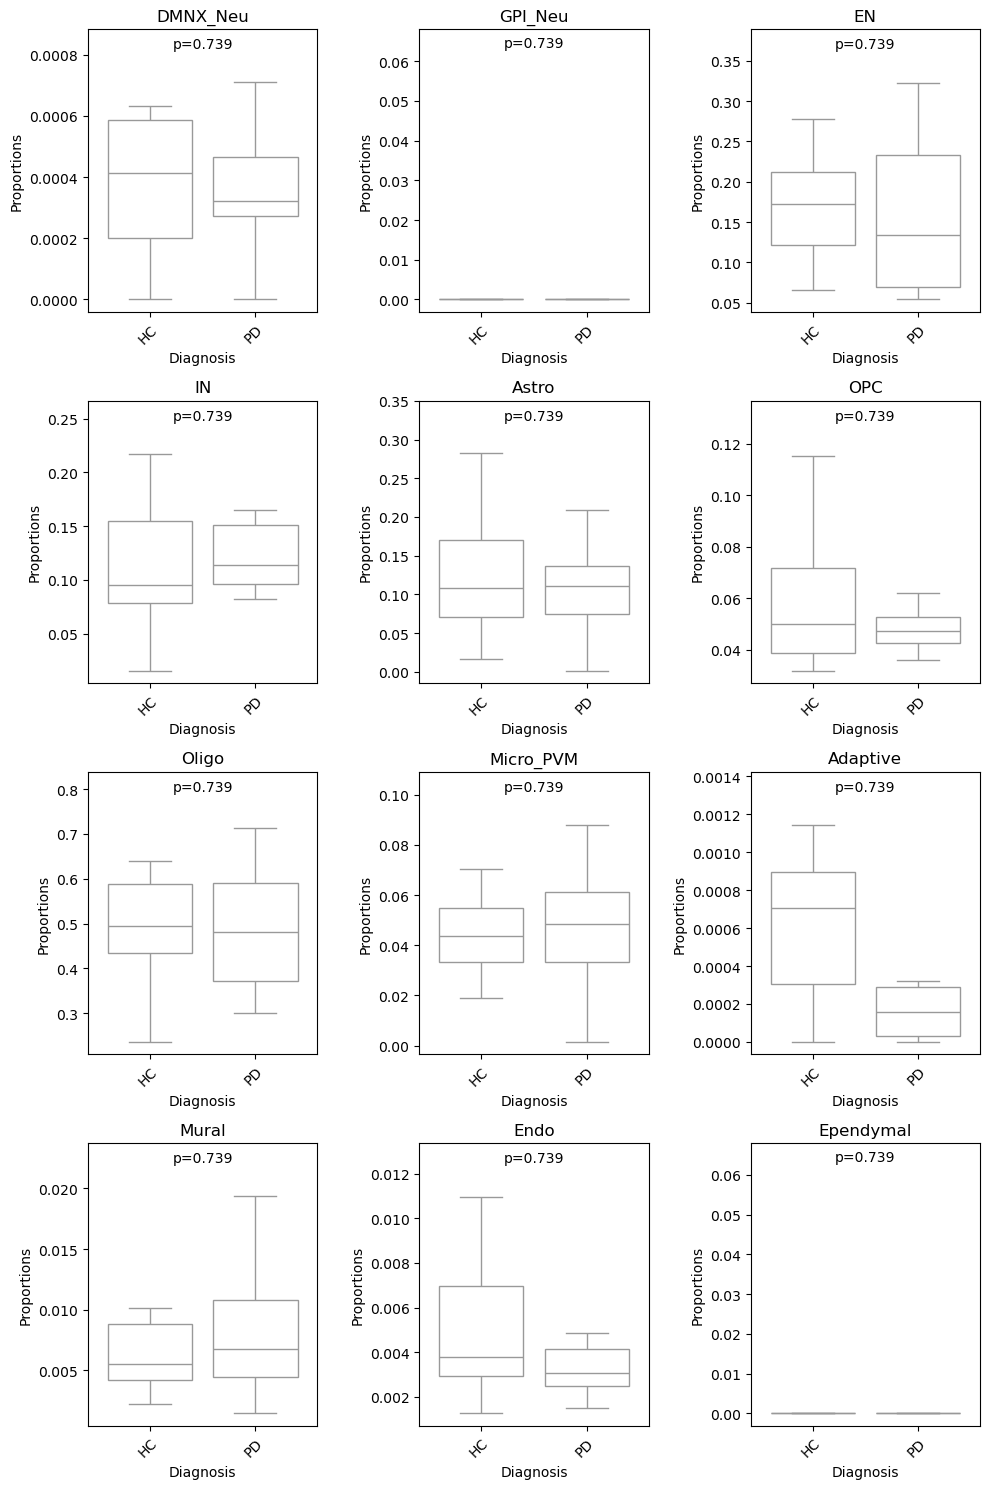

In [33]:
out.plot(kind="boxplot")

fig = plt.gcf() 

fig.set_size_inches(10, 15) 

for ax in fig.axes:
    ax.set_xlabel("Diagnosis") 


plt.tight_layout()

plt.savefig("main_clusters_boxplot.pdf", bbox_inches="tight")

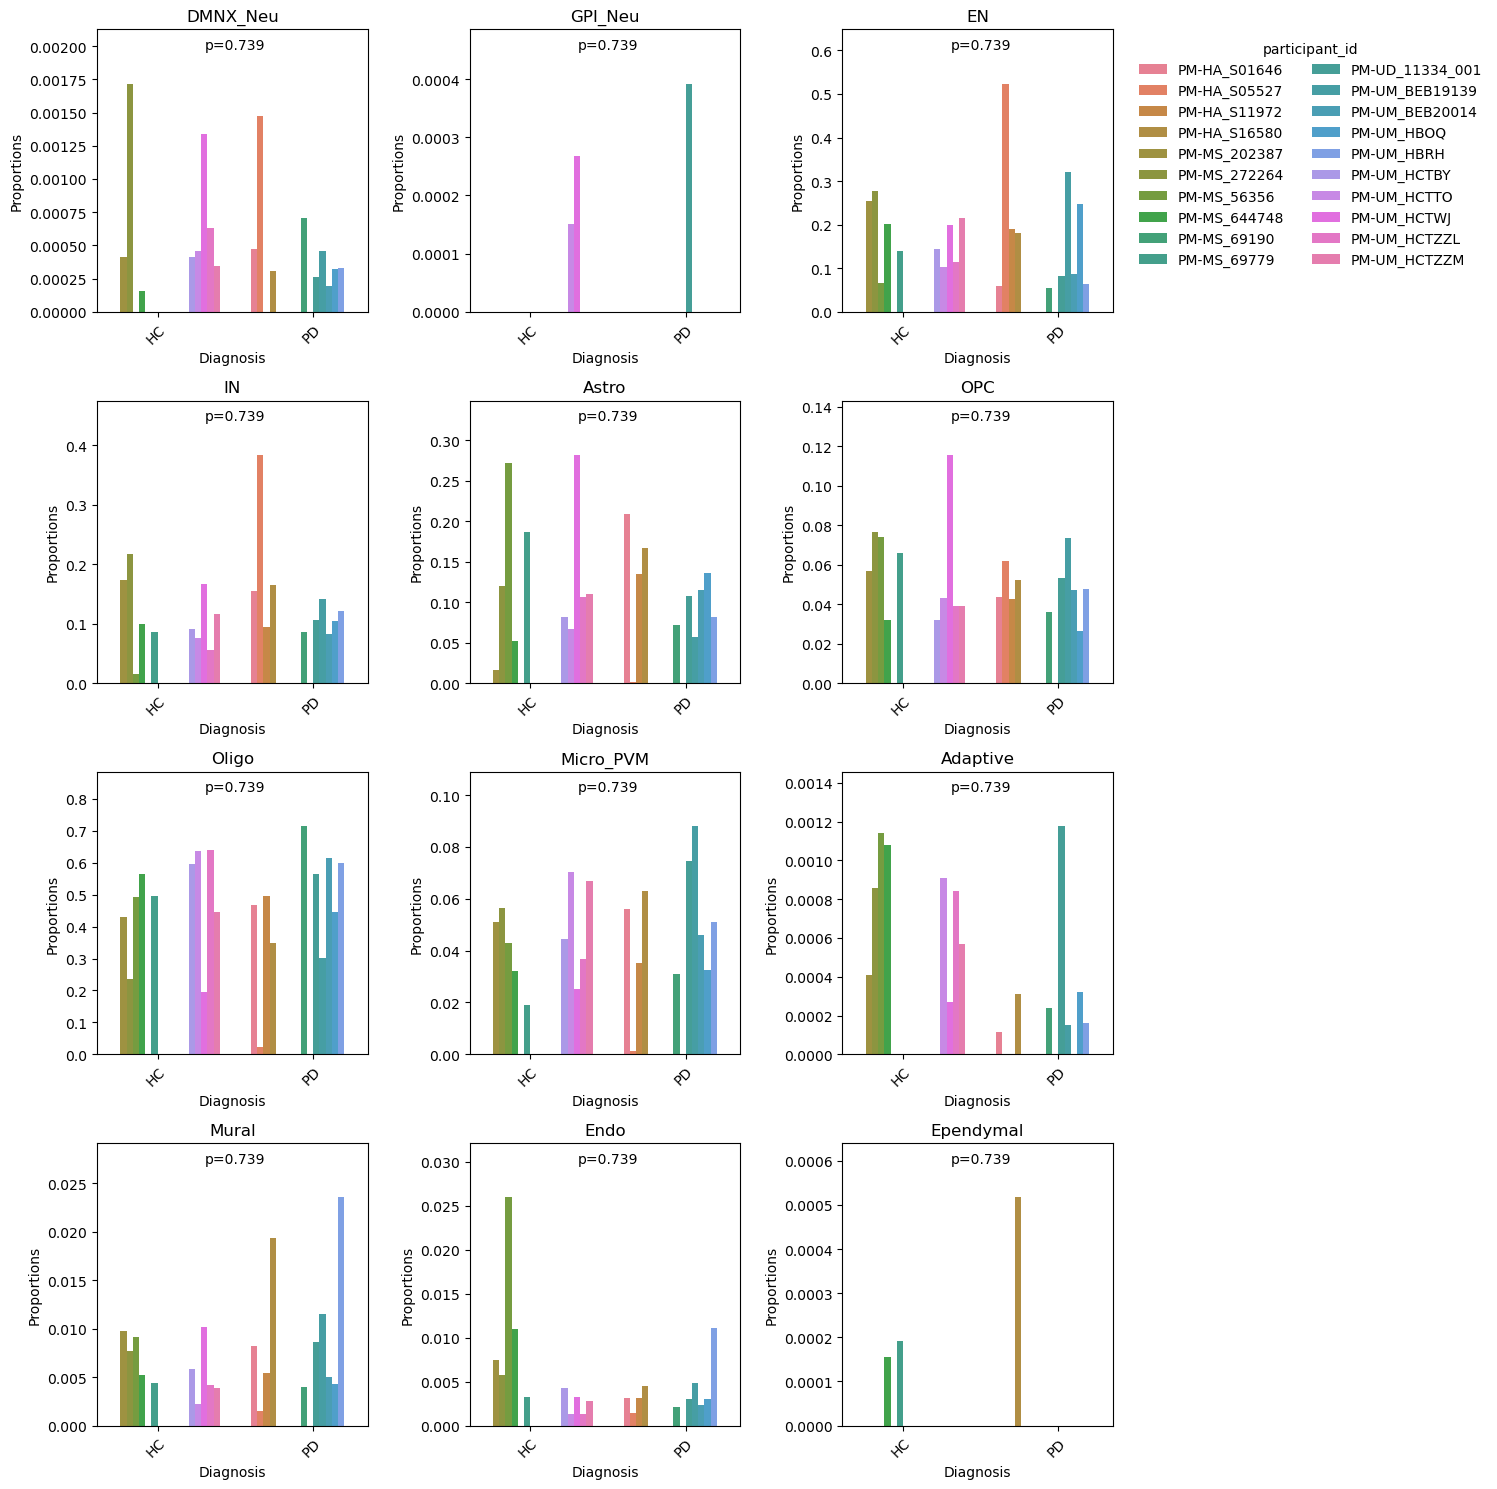

In [34]:
out.plot(kind="barplot")
fig = plt.gcf() 

fig.set_size_inches(15, 15) 

for ax in fig.axes:
    ax.set_xlabel("Diagnosis") 


plt.tight_layout()

plt.savefig("main_clusters_barplot.pdf", bbox_inches="tight")

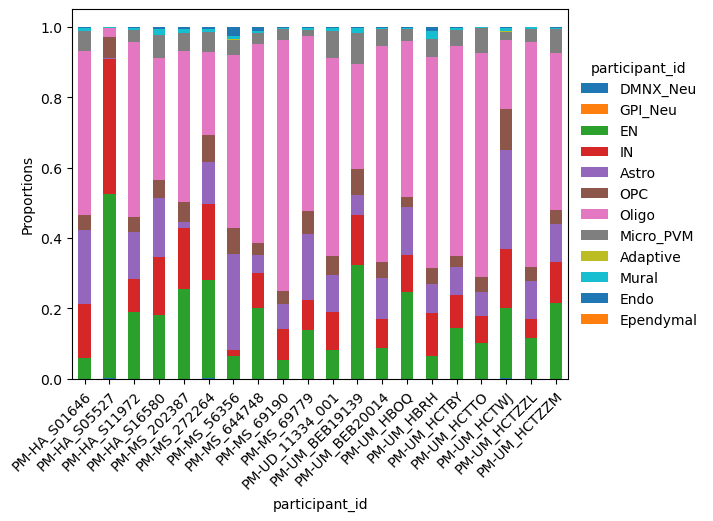

In [23]:
out.plot_samples(stacked=True)

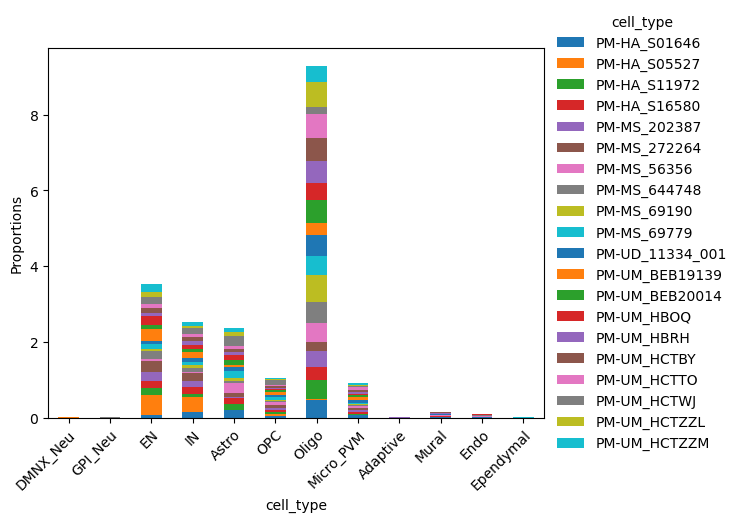

In [24]:
out.plot_samples(x="clusters")